# Predictive Modeling Challenge LSTM

**Mark Wilber**

The challenge here is to build a classifier for 56 FDA food safety violation categories, which are very unbalanced (sizes spanning more than 3 orders of magnitude). There are two components/features:

* a boolean, `FDAISCRITICAL`, indicating whether the violation is 'critical' or not
* a description of the violation, `VIOCOMMENT`, which can range from 0 to 844 'words'
  * (It is shown below, that the two instances with no comments can be safely dropped.)

This notebook generates TF-IDF features after extracting unigrams and bigrams, and trains models using logistic regression, random forest, linear SVC and complement Naive Bayes to compare f1 scores and training times.

<font color='darkgreen'>**As thise notebook is lengthy, readers will find it much easier to navigate with [Jupyter Nbextensions](https://github.com/ipython-contrib/jupyter_contrib_nbextensions) installed, and Table of Contents (2) selected:**</font>

## Preliminaries

**Next two lines are useful in the event of external code changes.**

In [1]:
%load_ext autoreload
%autoreload 2

### Python imports

**Next two lines are for pretty output for all prints in a Pandas cell, not just the last.**

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

**`DataSci` contains generally helpful data science stuff, while `plotHelpers` includes plot functions specifically.**

In [3]:
import sys
# sys.path.append('/home/wilber/work/Mlib')
sys.path.append('/home/mark/work/Mlib')
from utility import DataSci as util
from plotHelpers import plotHelpers as ph

In [4]:
from time import time, asctime, gmtime
print(asctime(gmtime()))

t0 = time()

# from platform import node
import os
from os.path import exists
# import shutil
# from glob import glob
from random import random
from collections import Counter, OrderedDict
import gc		# garbage collection module
import pathlib
import pprint
# import pickle
import timeit

print("Python version: ", sys.version_info[:])
print("Un-versioned imports:\n")
prefixStr = ''
if 'collections' in sys.modules:
    print(prefixStr + 'collections', end="")
    prefixStr = ', '
if 'gc' in sys.modules:
    print(prefixStr + 'gc', end="")
    prefixStr = ', '
if 'glob' in sys.modules:
    print(prefixStr + 'glob', end="")
    prefixStr = ', '
if 'pickle' in sys.modules:
    print(prefixStr + 'pickle', end="")
    prefixStr = ', '
if 'platform' in sys.modules:
    print(prefixStr + 'platform', end="")
    prefixStr = ', '
if 'plotHelpers' in sys.modules:
    print(prefixStr + 'plotHelpers', end="")
    prefixStr = ', '
if 'pprint' in sys.modules:
    print(prefixStr + 'pprint', end="")
    prefixStr = ', '
if 'os' in sys.modules:
    print(prefixStr + 'os', end="")
    prefixStr = ', '
if 'os.path' in sys.modules:
    print(prefixStr + 'os.path', end="")
    prefixStr = ', '
if 'random' in sys.modules:
    print(prefixStr + 'random', end="")
    prefixStr = ', '
if 'shutil' in sys.modules:
    print(prefixStr + 'shutil', end="")
    prefixStr = ', '
if 'sys' in sys.modules:
    print(prefixStr + 'sys', end="")
    prefixStr = ', '
if 'timeit' in sys.modules:
    print(prefixStr + 'timeit', end="")
    prefixStr = ', '
if 'utility' in sys.modules:
    print(prefixStr + 'utility', end="")
    # prefixStr = ', '

duVersion = None
from dateutil import __version__ as duVersion
from dateutil.parser import parse
import numpy as np
import pandas as pd
import pyreadr

scVersion = None
from scipy import __version__ as scVersion
import scipy.sparse as sp

skVersion = None
from sklearn import __version__ as skVersion
# from sklearn.feature_extraction import text
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.feature_selection import chi2
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
# from sklearn import metrics
# from sklearn.svm import LinearSVC, SVC
# from sklearn.naive_bayes import ComplementNB
from sklearn.utils import class_weight

tfVersion = None
from tensorflow import __version__ as tfVersion
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

jlVersion = None
from joblib import __version__ as jlVersion
from joblib import dump, load

import seaborn as sns
import colorcet as cc

mpVersion = None
from matplotlib import __version__ as mpVersion
import matplotlib.pyplot as plt

print("\n")
if 'colorcet' in sys.modules:
    print(f"colorcet: {cc.__version__}", end="\t")
if 'dateutil' in sys.modules:
    print(f"dateutil: {duVersion}", end="\t")
if 'joblib' in sys.modules:
    print(f"joblib: {jlVersion}", end="\t")
if 'matplotlib' in sys.modules:
    print(f"matplotlib: {mpVersion}", end="\t")
if 'numpy' in sys.modules:
    print(f"numpy: {np.__version__}", end="\t")
if 'pandas' in sys.modules:
    print(f"pandas: {pd.__version__}", end="\t")
if 'pyreader' in sys.modules:
    print(f"pyreader: {pyreader.__version__}", end="\t")
if 'scipy' in sys.modules:
    print(f"scipy: {scVersion}", end="\t")
if 'seaborn' in sys.modules:
    print(f"seaborn: {sns.__version__}", end="\t")
if 'sklearn' in sys.modules:
    print(f"sklearn: {skVersion}", end="\t")
if 'tensorflow' in sys.modules:
    print(f"tensorflow: {tfVersion}", end="\t")
# if '' in sys.modules:
#     print(f": {.__version__}", end="\t")
Δt = time() - t0
print(f"\n\nΔt: {Δt: 4.1f}s.")

%matplotlib inline

Sun Apr  5 21:22:01 2020
Python version:  (3, 6, 9, 'final', 0)
Un-versioned imports:

collections, gc, glob, pickle, platform, plotHelpers, pprint, os, os.path, random, shutil, sys, timeit, utility

colorcet: 1.0.0	dateutil: 2.8.1	joblib: 0.14.1	matplotlib: 3.1.3	numpy: 1.18.1	pandas: 1.0.1	scipy: 1.4.1	seaborn: 0.10.0	sklearn: 0.22.1	tensorflow: 2.1.0	

Δt:  1.2s.


### Helper functions

<a id="helper-tokenize"></a>
#### `tokenize()`

In [5]:
def tokenize(corpus, vocabSz):
    """
    Generates the vocabulary and the list of list of integers for the input corpus

    Help from: https://www.tensorflow.org/tutorials/text/nmt_with_attention

    INPUTS:
        corpus: list, type(str), containing (short) document strings
        vocabSz: (int) Maximum number of words to consider in the vocabulary

    RETURNS: List of list of indices for each title in the corpus + Keras sentence tokenizer object

    Usage:
        listOfListsOfIndices, sentenceTokenizer = tokenize(mySentences, maxVocabCt)
    """

    # Define the sentence tokenizer
    sentenceTokenizer = Tokenizer(num_words=vocabSz,
                                  filters='!#%()*+,./:;<=>?@[\\]^_`{|}~\t\n',
                                  lower=True,
                                  split=' ', char_level=False, oov_token="<unkwn>")

    # Keep the double quote, dash, and single quote + & (different from word2vec training: didn't keep `&`)
    # oov_token: added to word_index & used to replace out-of-vocab words during text_to_sequence calls
    # num_words = maximum number of words to keep, dropping least frequent

    # Fit the tokenizer on the input corpus
    sentenceTokenizer.fit_on_texts(corpus)

    # Transform each text in corpus to a sequence of integers
    listOfIndexLists = sentenceTokenizer.texts_to_sequences(corpus)

    return listOfIndexLists, sentenceTokenizer

#### `df2TFdata()`

This is modified from [a TensorFlow tutorial](https://www.tensorflow.org/tutorials/structured_data/feature_columns), replacing columnar feature with tokenized text for the inputs.

In [6]:
# def df2TFdata(dataframe, textCol, targetCol, shuffle=True, batchSz=64):
#     """
#     dataframe		pd.DataFrame, containing a column with text, and a target column with labels
#     shuffle			bool, indicating whether to shuffle the data, default: True
#     batchSz			int, indicating batch size, default: 64
#     """

#     dataframe = dataframe.copy()
#     labels = dataframe.pop(targetCol)
#     ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
#     if shuffle:
#         ds = ds.shuffle(buffer_size=len(dataframe))
#     ds = ds.batch(batch_size)

#     return ds

## Handle the data

### Read data into a DataFrame

* Have a very quick look at DataFrame characteristics

In [7]:
fname = "SelectedInspectionReportData.rds"

t0 = time()
result = pyreadr.read_r(fname)
df = result[None]
df.fda_q_fixed = df.fda_q_fixed.astype('int')
df.FDAISCRITICAL = df.FDAISCRITICAL.astype('int')
Δt = time() - t0
print(f"\n\nΔt: {Δt: 4.1f}s.")

df.shape



Δt:  7.5s.


(1307986, 12)

In [8]:
df.head(6).T
df.tail(6).T

,0,1,2,3,4,5
HZLVIOLATIONID,,,,,,
VIOCORRECTBYDATE,,,,,,
PICKLIST,6-301.11,4-601.11(A),4-204.112,3-302.12,6-404.11,4-501.11
VIOCOMMENT,Soap and/or paper towels are not provided for ...,Food contact surfaces and utensils are not cle...,An accurate product temperature-measuring devi...,Bulk containers are not properly labeled. V/C,Food products that are held by the food establ...,Non-food contact equipment is not maintained i...
FDAQUESTION,8,14,34,35,37,45
VIOISCOS,1,1,1,1,1,1
VIOLATIONID,,,,,,
FDAISCRITICAL,0,0,1,1,1,1
VIOISRPT,,,,,,
VIOCODE,,,,,,


,1307980,1307981,1307982,1307983,1307984,1307985
HZLVIOLATIONID,,,,,,
VIOCORRECTBYDATE,"January, 01 1900 00:00:00","January, 01 1900 00:00:00","January, 01 1900 00:00:00","January, 01 1900 00:00:00","January, 01 1900 00:00:00","January, 01 1900 00:00:00"
PICKLIST,6-501.11,6-501.12(1),3-305.11,4-903.11 (42),4-903.11 (42),4-501.11
VIOCOMMENT,"Floors, walls, and ceilings not in good repair","Floors, walls, and ceilings not clean",Food was not separated and protected from cont...,Equipment and utensils not properly installed ...,Equipment and utensils not properly stored or ...,Utensils and equipment unapproved or not in go...
FDAQUESTION,53,53,37,42,42,45
VIOISCOS,0,0,0,0,0,0
VIOLATIONID,100960663,100960664,100960679,100960681,100960682,100960680
FDAISCRITICAL,0,0,0,0,0,0
VIOISRPT,0,0,0,0,0,0
VIOCODE,53,53,37,45,42,45


#### Basic summary

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1307986 entries, 0 to 1307985
Data columns (total 12 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   HZLVIOLATIONID    1307986 non-null  object 
 1   VIOCORRECTBYDATE  1307986 non-null  object 
 2   PICKLIST          1307986 non-null  object 
 3   VIOCOMMENT        1307986 non-null  object 
 4   FDAQUESTION       1307986 non-null  object 
 5   VIOISCOS          1307986 non-null  object 
 6   VIOLATIONID       1307986 non-null  object 
 7   FDAISCRITICAL     1307986 non-null  int64  
 8   VIOISRPT          1307986 non-null  object 
 9   VIOCODE           1307986 non-null  object 
 10  JURISDICTIONID    1307986 non-null  float64
 11  fda_q_fixed       1307986 non-null  int64  
dtypes: float64(1), int64(2), object(9)
memory usage: 119.7+ MB


In [10]:
df.describe()

,FDAISCRITICAL,JURISDICTIONID,fda_q_fixed
count,1.307986e+06,1.307986e+06,1.307986e+06
mean,3.141234e-01,2.818328e+02,3.773050e+01
std,4.641660e-01,2.400974e+02,1.619210e+01
min,0.000000e+00,2.000000e+00,1.000000e+00
25%,0.000000e+00,1.360000e+02,2.200000e+01
50%,0.000000e+00,1.530000e+02,4.400000e+01
75%,1.000000e+00,3.880000e+02,5.000000e+01
max,1.000000e+00,9.730000e+02,5.600000e+01


#### Remove columns from DataFrame which we won't need

In [11]:
df = df[['fda_q_fixed', 'VIOCOMMENT', 'FDAISCRITICAL']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1307986 entries, 0 to 1307985
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   fda_q_fixed    1307986 non-null  int64 
 1   VIOCOMMENT     1307986 non-null  object
 2   FDAISCRITICAL  1307986 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 29.9+ MB


### Exploratory analysis

#### Classes and relative balance

* The stuff using patches is for placing counts above each rectangle in the bar plot

In [12]:
FDAcodes = list(set(df['fda_q_fixed'].values))
print(FDAcodes)
classCts = pd.DataFrame(df['fda_q_fixed'].value_counts())
with pd.option_context("display.max_columns", 60):
    display(classCts.T)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]


,55,49,47,16,10,22,51,56,39,44,41,38,54,48,43,28,40,45,36,8,21,15,6,24,53,37,23,2,33,1,50,20,13,9,52,35,3,29,18,25,5,11,19,14,4,42,31,46,17,12,32,7,26,30,27,34
fda_q_fixed,171202,122314,121997,103357,69288,57210,56230,51223,46145,45333,42241,37133,30016,27602,26638,24426,24016,22845,21351,20585,18874,18156,15947,15218,13428,13294,12675,12630,11494,7844,7019,5747,5495,4213,3738,3513,2774,1910,1859,1770,1602,1550,1351,933,883,849,492,464,348,225,216,166,63,34,33,27


fileNameAugmentString:
 FdaCodeFrequencies
Δt:  0.34s.


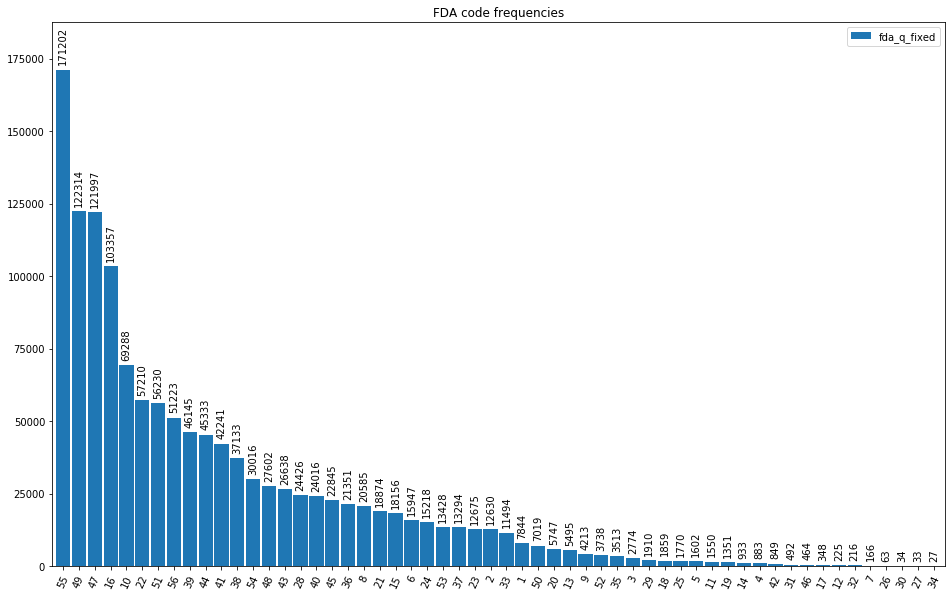

In [13]:
ph.plotValueCounts(df, 'fda_q_fixed', titleText='FDA code frequencies', saveAs='svg', ylim=[0.0, 187500.0])

***The class sizes span nearly 4 orders of magnitude!***

#### Word frequencies

In [14]:
t0 = time()
df['commentsWords'] = df['VIOCOMMENT'].apply(lambda s: s.split())
t1 = time()
Δt = t1 - t0
print(f"Δt: {Δt % 60.0:4.1f}s.")

Δt:  7.2s.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
comments = list(df['commentsWords'])
print(comments[0])
print(comments[-1])

['Soap', 'and/or', 'paper', 'towels', 'are', 'not', 'provided', 'for', 'use', 'at', 'the', 'hand', 'wash', 'lavatory.', 'V/C']
['Utensils', 'and', 'equipment', 'unapproved', 'or', 'not', 'in', 'good', 'repair']


##### Distribution of comment lengths

* Add length of each comment to DataFrame as `wordFreq` column

In [16]:
wordLens = [len(wordList) for wordList in comments]
df['wordFreq'] = wordLens
wordFreqMode = df['wordFreq'].mode().values[0]

wordCtSorted = sorted(wordLens)
print("smallest word counts:\n", wordCtSorted[:100])
print("largest word counts:\n", wordCtSorted[-101:-1])

smallest word counts:
 [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
largest word counts:
 [434, 434, 434, 440, 440, 440, 440, 440, 440, 441, 441, 442, 453, 454, 454, 458, 464, 464, 464, 464, 464, 464, 466, 466, 474, 474, 476, 476, 476, 480, 480, 481, 481, 481, 488, 498, 498, 498, 498, 503, 506, 506, 511, 511, 511, 533, 533, 534, 534, 535, 535, 536, 536, 536, 538, 538, 539, 542, 542, 542, 547, 552, 552, 553, 553, 564, 577, 577, 580, 580, 580, 580, 580, 580, 594, 594, 615, 615, 615, 619, 619, 619, 628, 628, 644, 644, 644, 649, 649, 670, 670, 670, 671, 671, 782, 782, 787, 787, 806, 806]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Detailed histogram**

Found  844 bins in data array.
fileNameAugmentString:
 WordCountsMax844Mode8
Saving as  WordCountsHistWordCountsMax844Mode8.svg .
Δt:  1.45s.


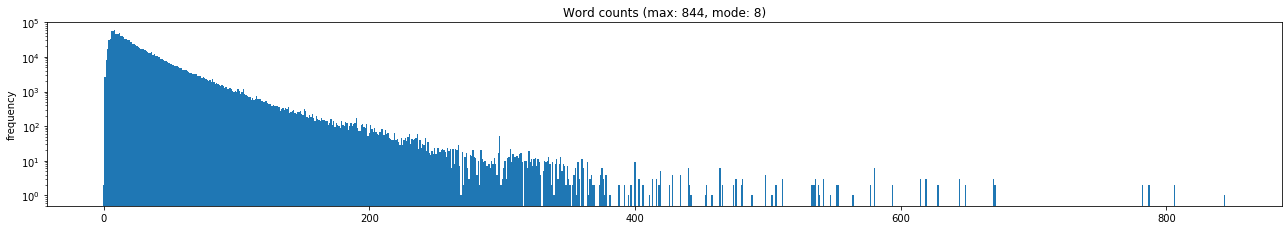

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(18, 3.5))

ph.detailedHistogram(wordLens, ylabel='frequency', volubility=2,
                     titleText=f"Word counts (max: {wordCtSorted[-1]}, mode: {wordFreqMode})",
                     figName="WordCountsHist", ax=ax, ylim = [0.5, 100000.0], ylog=True, saveAs='svg')

**Make space**

In [18]:
del wordLens
del wordCtSorted
del df['commentsWords']

##### What FDA codes correspond to those comments having `wordFreq== 0`?

In [19]:
df[df['wordFreq']==0]
print("\n", df.shape)

,fda_q_fixed,VIOCOMMENT,FDAISCRITICAL,wordFreq
610833,49,,1,0
610835,49,,1,0



 (1307986, 4)


**Can safely remove a couple of records from the 2nd-most populated category**

* Originally there were 1307986 records in `df`, out of which 122314 were in Class 49

In [20]:
df = df[df['wordFreq']!=0]
df.shape

(1307984, 4)

##### `wordFreq` percentiles

* These show that would get 99% coverage of the comments without truncation if were to use, say, 140-element LSTMs

In [21]:
df.describe(percentiles=[0.01, 0.05, 0.15, 0.25, 0.5, 0.75, 0.85, 0.95, 0.99])

,fda_q_fixed,FDAISCRITICAL,wordFreq
count,1.307984e+06,1.307984e+06,1.307984e+06
mean,3.773048e+01,3.141223e-01,2.734516e+01
std,1.619211e+01,4.641656e-01,2.859241e+01
min,1.000000e+00,0.000000e+00,1.000000e+00
1%,2.000000e+00,0.000000e+00,3.000000e+00
5%,9.000000e+00,0.000000e+00,5.000000e+00
15%,1.600000e+01,0.000000e+00,7.000000e+00
25%,2.200000e+01,0.000000e+00,1.000000e+01
50%,4.400000e+01,0.000000e+00,1.800000e+01
75%,5.000000e+01,1.000000e+00,3.500000e+01


#### Most-common words

In [22]:
allWords = [word for wordList in comments for word in wordList]		# Flatten list of lists of words
print(len(comments), len(allWords))

print(comments[:5], "\n", allWords[:25])

1307986 35767027
[['Soap', 'and/or', 'paper', 'towels', 'are', 'not', 'provided', 'for', 'use', 'at', 'the', 'hand', 'wash', 'lavatory.', 'V/C'], ['Food', 'contact', 'surfaces', 'and', 'utensils', 'are', 'not', 'clean', 'to', 'sight', 'and', 'touch.', 'V/C'], ['An', 'accurate', 'product', 'temperature-measuring', 'device', 'is', 'not', 'provided.', 'V/C'], ['Bulk', 'containers', 'are', 'not', 'properly', 'labeled.', 'V/C'], ['Food', 'products', 'that', 'are', 'held', 'by', 'the', 'food', 'establishment', 'for', 'credit,', 'redemption', 'or', 'return', 'to', 'the', 'distributor', 'are', 'not', 'segregated', 'and', 'held', 'in', 'designated', 'areas', 'that', 'are', 'separated', 'from', 'food,', 'equipment,', 'utensils,', 'linens,', 'and', 'single', 'use', 'utensils/articles.', 'V/C']] 
 ['Soap', 'and/or', 'paper', 'towels', 'are', 'not', 'provided', 'for', 'use', 'at', 'the', 'hand', 'wash', 'lavatory.', 'V/C', 'Food', 'contact', 'surfaces', 'and', 'utensils', 'are', 'not', 'clean', 'to

In [23]:
t0 = time()
wordCtr = Counter(allWords)
t1 = time()
Δt = t1 - t0
print(f"Δt: {Δt % 60.0:4.1f}s.")

Δt:  4.3s.


##### Most common words, after removing stop words

*Result looks very plausible*

In [24]:
stopWords = text.ENGLISH_STOP_WORDS.union(['-'])

wcStops = [k for k in wordCtr if k.lower() in stopWords]
for k in wcStops:
    del wordCtr[k]
wordCtr.most_common(40)

[('food', 416195),
 ('Observed', 199727),
 ('stored', 190927),
 ('Basic', 172943),
 ('shall', 164416),
 ('sink', 135404),
 ('clean', 134875),
 ('cooler', 127169),
 ('equipment', 116502),
 ('surfaces', 101198),
 ('ice', 98110),
 ('properly', 92639),
 ('floor', 89994),
 ('area', 89722),
 ('water', 89455),
 ('Food', 88648),
 ('contact', 87364),
 ('used', 85530),
 ('hand', 85441),
 ('temperature', 83565),
 ('**Warning**', 83220),
 ('prep', 82074),
 ('time', 77755),
 ('observed', 77699),
 ('storage', 72918),
 ('utensils', 66834),
 ('employee', 65779),
 ('On-Site**', 65728),
 ('**Corrected', 65545),
 ('machine', 65157),
 ('use', 64437),
 ('area.', 62940),
 ('Clean', 62534),
 ('cold', 62019),
 ('inspection', 61344),
 ('Correction:', 60798),
 ('holding', 60728),
 ('good', 60532),
 ('line', 60306),
 ('items', 58171)]

#### Clean up

In [25]:
del allWords
del wordCtr

#### `fda_q_fixed` vs. `FDAISCRITICAL`

What is the relationship between the critical violation boolean and the FDA code?

In [26]:
dfCrit = df.groupby(['fda_q_fixed', 'FDAISCRITICAL']).count()
del dfCrit['VIOCOMMENT']
del dfCrit['wordFreq']
dfCrit.head(20)

dfCrit.reset_index(inplace=True)
dfCrit.head(20)

Empty DataFrame
Columns: []
Index: [(1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1), (4, 0), (4, 1), (5, 0), (5, 1), (6, 0), (6, 1), (7, 1), (8, 0), (8, 1), (9, 0), (9, 1), (10, 0), (10, 1), (11, 0)]

,fda_q_fixed,FDAISCRITICAL
0,1,0
1,1,1
2,2,0
3,2,1
4,3,0
5,3,1
6,4,0
7,4,1
8,5,0
9,5,1


Text(0.5, 0.98, 'Critical violations vs FDA code')

(0.5, 56.5)

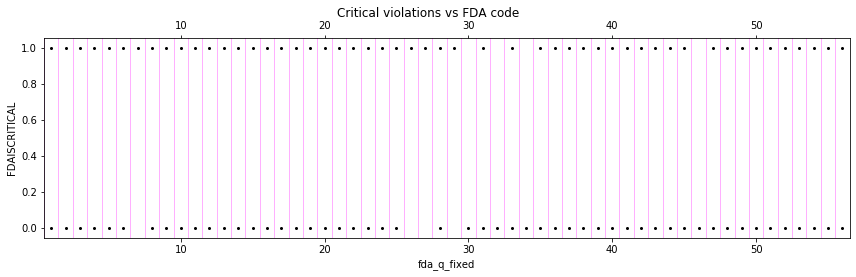

In [27]:
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.labeltop'] = True

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
dfCrit.plot.scatter('fda_q_fixed', 'FDAISCRITICAL', s=4, c='black', ax=ax)
for xv in np.linspace(0.5, 56.5, 57):
    _ = plt.axvline(x=xv, c="#FFB0FF", linewidth=1)
plt.suptitle('Critical violations vs FDA code')
ax.set_xlim([0.5, 56.5])
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig('CriticalViolationVsFDAcode.svg')

**The critical violations plot shows that `FDAISCRITICAL` should be predictive (and certainly should be included in the model):**

* **<font color="darkgreen">classes 30, 32, 34 &amp; 46 *never* have critical violations</font>**
* **<font color="darkgreen">classes 7, 26, 27 &amp; 29 *only* have critical violations</font>**

## Model Parameters

* testFrac				fraction of data set withheld
* maxVocabCt			vocabulary size returned by Tokenizer, dropping least frequent
* LSTMlayerUnits		# units within each activation unit in LSTMs]
* embeddingDim			size of dimension for generated embeddings
* auxFeaturesCt			# of features in auxiliary data
* classCt				# classes (softmax output dim)
* dropoutFrac			dropout fraction
* LSTMdropoutFrac		dropout fraction within LSTMs
* batchSz				size of batches
* epochCt				number of epochs to run

In [43]:
testFrac = 0.4
maxVocabCt = 80000
maxCommentWords = 140
LSTMlayerUnits = 64
embeddingDim = 64
auxFeaturesCt = 1
classCt = 56
dropoutFrac = 0.15
LSTMdropoutFrac = 0.5
batchSz = 64
epochCt = 10

## Pre-process data

* Here we use TF-IDF features to represent the comment text.

### Split DataFrame by classes

* create a `numpy.random.RandomState` instance to keep track of the random number initializer, in order to ensure consistent results throughout

`splitDataFrameByClasses()` will create two new DataFrames, dfTr, dfTe, according to the desired splits.

<font color='darkgreen'><b>Note that if you just want to do stratified sampling on a numpy array of</b> `X` <b>values,</b> `splitDataFramByClasses()` <b>is not needed.</b> `train_test_split()` <b>accepts the keyword</b> `stratify=myTargetVariable`.</b></font>

* Splitting is done on a per-class basis, so that random selection will not, by chance, yield huge imbalances in train-test splits of tiny classes

In [29]:
randomState=0
myRandomState = np.random.RandomState(randomState)

In [30]:
classColumn = 'fda_q_fixed'
dfTr, dfTe = util.splitDataFrameByClasses(df, classColumn,
                                          testFrac=testFrac,
                                          myRandomState=myRandomState)
dfTr.shape, dfTe.shape
dfTr.head()
dfTe.head()

Consider whether sklearn's built-in method would work instead:

    from sklearn.model_selection import     train_test_split
                  .
                  .
                  .
    Xtrain, Xtest, yTrain, yTest = \
        train_test_split(X, y, stratify=y)
df.shape: (1307984, 4)
dfTrain.shape: (784767, 4)	dfTest.shape: (523217, 4)
Δt:  1.88s.


((784767, 4), (523217, 4))

,fda_q_fixed,VIOCOMMENT,FDAISCRITICAL,wordFreq
0,41,Wiping cloths; propelry used and stored,0,6
1,41,Wiping cloths observed lying on counters inste...,0,39
2,49,Food and nonfood contact surfaces properly des...,0,45
3,47,Remove plastic,0,2
4,10,Observed that paper towels were not provided a...,1,38


,fda_q_fixed,VIOCOMMENT,FDAISCRITICAL,wordFreq
0,41,"CONTAMINATION FROM WIPING CLOTHS - Clean, prop...",0,48
1,3,Facility had no employee health agreements on ...,1,43
2,21,French onion soup at table-top hot holding uni...,1,22
3,47,The caulking at the front cook line ventilatio...,0,12
4,15,2-301.11 Keep hands and arms clean. -P Observe...,1,51


**As intended, `splitBalancedDataFrameClasses()` created new test and train DataFrames, each with ~ 1307984/2 = 653992 rows.**

*The test DataFrame is not an exactly split of the original, since the splitting is done by class and unioned. For a 50% split, sci-kit learn's* `train_test_split()` gives the extra instance in each odd-sized class to the test set.*

### Create list of lists of word indices, and TensorFlow sentence tokenizer object

Use comment strings from `dfTrain` to create vocabulary indices.

See [helper function `tokenize()`](#helper-tokenize)

In [31]:
ListOfCommentsTr = list(dfTr.VIOCOMMENT)

listOfListsOfWordIndicesTr, sentenceTokenizer = tokenize(ListOfCommentsTr, maxVocabCt)

### Pre-pad short comment lists, truncate the ends of long comments

In [32]:
# padValue = max(max(listOfListsOfWordIndices)) + 1
padValue = 0
XcommentsTr = pad_sequences(listOfListsOfWordIndicesTr,
                            maxlen=maxCommentWords,
                            dtype='int32', padding='pre',
                            truncating='post', value=padValue)

In [33]:
ListOfCommentsTr[0]
listOfListsOfWordIndicesTr[0]
XcommentsTr[0]

'Wiping cloths; propelry used and stored'

[111, 166, 1636, 56, 3, 21]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,  111,  166, 1636,   56,    3,   21], dtype=int32)

### Auxiliary (side) data need to be shaped

In [34]:
XauxTr = dfTr.FDAISCRITICAL.values.reshape(dfTr.shape[0], 1)
XauxTr.shape

(784767, 1)

### Train target data

In [35]:
FDAcodesTr = dfTr.fda_q_fixed - 1
print(set(FDAcodesTr))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55}


### Tensor of word indices for test

In [36]:
ListOfCommentsTe = list(dfTe.VIOCOMMENT)
listOfListsOfWordIndicesTe = sentenceTokenizer.texts_to_sequences(ListOfCommentsTe)
XcommentsTe = pad_sequences(listOfListsOfWordIndicesTe,
                            maxlen=maxCommentWords,
                            dtype='int32', padding='pre',
                            truncating='post', value=padValue)

### Auxiliary test data

In [37]:
XauxTe = dfTe.FDAISCRITICAL.values.reshape(dfTe.shape[0], 1)
XauxTe.shape

(523217, 1)

### Test target data

In [38]:
FDAcodesTe = dfTe.fda_q_fixed - 1
print(set(FDAcodesTe))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55}


## Model time

### Define the model

This follows, to some degree, [Keras Multi-Input and multi-output models](https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models)

* In this case, we only have a single output
* Here, Bidirectional LSTMs are used

In [40]:
def buildModel(sequence_length, vocabSz, auxFeatureCount, LSTMinternalLayerSz,
               embedLayerDim, densLayerDim=64, softMaxCt=16, dropoutFrac=0.15,
               LSTMdropoutFrac=0.40):

    """
    INPUTS:
    sequence_length				int, number of LSTM units
    vocabSz					int, size of vocabulary
    auxFeatureCount		int, count of auxiliary (side) features
    LSTMinternalLayerSz					int, size of layers within LSTM units
    embedLayerDim						int, dimension of embedding layer
    densLayerDim					int, dimension of dense layers, default: 64
    softMaxCt				int, dimension of softmax output, default: 16
    dropoutFrac				int, dropout rate, default: 0.50 [currently not used]
    """

    # Headline input: meant to receive sequences of *sequence_length* integers, between 1 and *vocabSz*.
    # Note that we can name any layer by passing it a "name" argument.
    main_input = Input(shape=(sequence_length,), dtype='int32', name='main_input')

    # This embedding layer will encode the input sequence
    # into a sequence of dense 64-dimensional vectors.
    x = Embedding(output_dim=embedLayerDim, input_dim=vocabSz,
                  input_length=sequence_length, trainable=True)(main_input)

    # A LSTM will transform the vector sequence into a single vector,
    # containing information about the entire sequence
    lstm_out_1 = Bidirectional(LSTM(LSTMinternalLayerSz,
                                    dropout=dropoutFrac,
                                    recurrent_dropout=LSTMdropoutFrac,
                                    return_sequences=True))(x)
    lstm_out = LSTM(LSTMinternalLayerSz,
                    dropout=dropoutFrac,
                    recurrent_dropout=LSTMdropoutFrac)(lstm_out_1)

    auxiliary_input = Input(shape=(auxFeatureCount,), name='numerical_input')
    x = concatenate([lstm_out, auxiliary_input])

    # We stack a deep densely-connected network on top
    x = Dense(densLayerDim, activation='relu')(x)
    x = Dense(densLayerDim, activation='relu')(x)

    # And finally we add the main logistic regression layer
    main_output = Dense(56, activation='softmax', name='main_output')(x)
    model = Model(inputs=[main_input, auxiliary_input], outputs=main_output)
    
    return model

### Instantiate the model

In [41]:
np.random.seed(0)  # Set a random seed for reproducibility
modelLSTM = buildModel(maxCommentWords, maxVocabCt, auxFeaturesCt,
                       LSTMlayerUnits, embeddingDim, softMaxCt=classCt)
modelLSTM.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 140)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 140, 64)      5120000     main_input[0][0]                 
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 140, 128)     66048       embedding[0][0]                  
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 64)           49408       bidirectional[0][0]              
______________________________________________________________________________________________

### Compute weights for each class

In [ ]:
dfTr.fda_q_fixed.unique() - 1

In [ ]:
classWeights = class_weight.compute_class_weight('balanced',
                                                 dfTr.fda_q_fixed.unique() - 1,
                                                 dfTr.fda_q_fixed - 1)

### Define callbacks for model checkpoints and TensorBoard

In [47]:
checkpointDir = './checkpoints'

tensorBoardLogDir = './tensorBoardLogs'
os.makedirs(tensorBoardLogDir, exist_ok=True)

logDir = (f"vocabCt{maxVocabCt:06d}maxCommentLen{maxCommentWords:03d}auxFeaturesCt{auxFeaturesCt:02d}"
          + f"classCt{classCt:02d}embedDim{embeddingDim:03d}LSTMlayerSz{LSTMlayerUnits:03d}"
          + f"batchSz{batchSz:03d}dropoutFrac{dropoutFrac:4.2f}LSTMdropoutFrac{dropoutFrac:4.2f}")

logsDir = os.path.join(tensorBoardLogDir, logDir)

checkpointPrefix = os.path.join(checkpointDir, logDir, "ckpt{epoch:03d}")
checkpoint_callback=ModelCheckpoint(filepath=checkpointPrefix,
                                    save_weights_only=True)


os.makedirs(logsDir, exist_ok=True)
tensorboard_callback = TensorBoard(log_dir=logsDir, histogram_freq=1)

### Compile the model

In [42]:
modelLSTM.compile(optimizer='rmsprop',
                  loss='sparse_categorical_crossentropy',
                  metrics = ['accuracy', 'categorical_crossentropy'])

### Run the model

In [ ]:
history = modelLSTM.fit(x=[XcommentsTr, XauxTr],
                        y= FDAcodesTr,
                        epochs=epochCt, batch_size=batchSz,
                        shuffle=True,
                        class_weight=classWeights,
                        validation_split=0.2,
                        callbacks=[checkpoint_callback, tensorboard_callback], verbose=1)

Train on 627813 samples, validate on 156954 samples
Epoch 1/10
627813/627813 [==============================] - 4801s 8ms/sample - loss: 0.8503 - accuracy: 0.7743 - categorical_crossentropy: 30938.5488 - val_loss: 0.6547 - val_accuracy: 0.8270 - val_categorical_crossentropy: 30172.9941
Epoch 2/10
627813/627813 [==============================] - 4765s 8ms/sample - loss: 0.6602 - accuracy: 0.8282 - categorical_crossentropy: 35109.4375 - val_loss: 0.6289 - val_accuracy: 0.8347 - val_categorical_crossentropy: 37760.3984
Epoch 3/10
324672/627813 [==============>...............] - ETA: 37:11 - loss: 0.6493 - accuracy: 0.8316 - categorical_crossentropy: 36582.9180

In [ ]:
# history = modelLSTM.fit({'main_input': paddedSequences, 'numerical_input': bools},
#                         {'main_output': FDAcodes}, epochs=5, batch_size=batchSz)

In [ ]:
modelLSTM.save(current_iteration + '/save')

### Do inference on test

In [ ]:
softmaxOut = modelLSTM.predict(x=[XcommentsTe, XauxTe])

In [ ]:
yPred = np.argmax(softmaxOut, axis=1) + 1

In [ ]:
dfTe.head(3)
dfTe.shape

#### Overall accuracy, precision, recall

In [ ]:
yTe = dfTe.fda_q_fixed
confusionMat = confusion_matrix(yTe, yPred)
print(confusionMat)

In [ ]:
%reset out

In [ ]:
np.where(np.sum(confusionMat, axis=0) == 0)

In [ ]:
accuracy = np.trace(confusionMat)/np.sum(confusionMat)
recall = np.diag(confusionMat)/np.sum(confusionMat, axis=1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis=0)
print(f"accuracy: {accuracy:0.3f}, "
      f"<precision>: {np.mean(precision):0.3f}, "
      f"<recall>: {np.mean(recall):0.3f}")

##### Recall, precision by class

Note:

* `macro avg`: $\frac{1}{K}\sum_k m_k$, where $K$ is count of classes and $m_k$ is a given metric for class $k$
* `weighted avg`: $\frac{1}{N}\sum_k n_k \cdot m_k$, where $N$ is count of data instance, $n_k$ is the count of points in class $k$ and $m_k$ is a given metric for class $k$.

In [ ]:
print(metrics.classification_report(yTe, yPred, target_names=[str(c)for c in FDAcodes]))

In [ ]:
classCts = dfTe['fda_q_fixed'].value_counts()

recall = np.diag(confusionMat)/np.sum(confusionMat, axis = 1)
precision = np.diag(confusionMat)/np.sum(confusionMat, axis = 0)
f1 = 2.0*precision*recall/(precision + recall)
print("class\tprecision\trecall\tf1\tsize")

for FDAcode, classCt in classCts.iteritems():
    print(f"{FDAcode}\t{precision[FDAcode - 1]:0.3f}\t\t{recall[FDAcode - 1]:0.3f}\t{f1[FDAcode - 1]:0.3f}\t\t{classCt:d}")

##### Plot confusion matrix

* As this is a straight confusion matrix, diagonal elements mostly reflect class size in test set
* *This is hard to interpret by visual inspection alone*

In [ ]:
labelFontSz = 16
tickFontSz = 13
titleFontSz = 20

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes,
                       ylabels=FDAcodes, titleText = 'Logistic Regression',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot recall confusion matrix (normalized by row)

* diagonal elements now represent the *recall* for each class

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes, type='recall',
                       ylabels=FDAcodes, titleText = 'Logistic Regression',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)

##### Plot precision confusion matrix (normalized by column)

* diagonal elements now represent the *precision* for each class

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ph.plotConfusionMatrix(confusionMat, saveAs='pdf', xlabels=FDAcodes, type='precision',
                       ylabels=FDAcodes, titleText = 'Logistic Regression',
                       ax = ax,  xlabelFontSz=labelFontSz,
                       ylabelFontSz=labelFontSz, xtickFontSz=tickFontSz,
                       ytickFontSz=tickFontSz, titleFontSz=titleFontSz)